# SVP100 - Hitting The Wall

In August of 2017 I ran the SVP100. This is a 100KM trail running race starting in Newmarket (Suffolk, UK) and ending in Manning Tree (Essex, UK). In regular distance marathons, its widely believed runners "hit the wall" at around 30KM mark (or 70% through the race). In this notebook, I want to see if the same holds true over a 100KM distance.

From a high level, the code below performs the following:

1. Scrape results data from the race website (using Beautiful Soup)

2. Render scraped data into a DataFrame (using Pandas)

3. Format (or wrangle) the data into formats we can work with

4. Present results in time series graph (using Seaborn)

## 1. Import packages and set configurations

First, let's import some packages. We'll use BeautifulSoup for web scraping, pandas for data analysis, and then seaborn for plotting. 

In [1]:
# Import the packages we'll use for our analysis
import datetime
import time
import requests

from bs4 import BeautifulSoup
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

Then we set the plotting configuration. I really like the "fivethirtyeight" stylesheet which generates plots in the style used by fivethirtyeight.com.

In [2]:
# Use line magic function to enable matplotlib to work interactively with iPython

%matplotlib inline
%pylab inline

# Set style to fivethirtyeight to create clean and clear looking graphs

plt.style.use('fivethirtyeight')

# Define a dictionary containing default plotting configurations

params = {'legend.fontsize': 'small',
          'figure.figsize': (12, 4.5),
         'axes.labelsize': 'small',
         'axes.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}

pylab.rcParams.update(params)

Populating the interactive namespace from numpy and matplotlib


In [3]:
BASE_URL = "http://www.svp100.co.uk/results-"
YEAR = 2017

## 2. Generate unformatted table of race data

In [122]:
def df_builder(base_url=BASE_URL, year=YEAR):
    
    """
    This function returns a pandas DataFrame which contain data scraped from the race website.
    The data is unformatted.
    
    Attributes:
    -----------
    base_url: the url which contains race data in HTML
    year: the year for we would like data
    """
    
    # Scrape the data from the race website
    url = base_url + str(year)
    r = requests.get(url).text
    soup = BeautifulSoup(r, 'lxml')
    
    # Find tables from the html
    rows = soup.find_all('tr')[1:]
    
    # Collect and format column names for the dataframe
    column_html = soup.find_all('th')[:]    
    columns = [i.contents[0].lower().replace("/","").replace(" ", "_") for i in column_html if i.contents[0]]

    # Build a dataframe
    data = []
    for line in rows:
        row = line.find_all('td')
        row_list = []
        for counter, value in enumerate(row):
            row_list.append(row[counter].string)
        data.append(row_list)
            
    return pd.DataFrame(data, columns=columns).drop(columns = ["name", "club"]).set_index("position")


In [123]:
unformatted_df = df_builder(BASE_URL, YEAR)

In [124]:
unformatted_df.tail(2)

,bib,mf,start,cp1,cp2,cp3,cp4,cp5,cp6,finish,total_time
position,,,,,,,,,,,
91,162,Female,07:00:00,09:51:33,DNF,None,None,None,None,None,None
92,7,Male,08:30:00,10:23:05,DNF,None,None,None,None,None,None


## 3. Clean the table of race data

In [125]:
dt_cols = ["start", "cp1", "cp2", "cp3", "cp4", "cp5", "cp6", "finish", "total_time"]
unformatted_df = unformatted_df.dropna()


In [126]:


for col in dt_cols:
    
    unformatted_df[col] = unformatted_df[col].apply(lambda x: pd.to_datetime("2017-08-08 " + str(x)))
        
    
    

In [128]:
unformatted_df["time2cp1"] = unformatted_df.cp1 - unformatted_df.start

In [129]:
unformatted_df

,bib,mf,start,cp1,cp2,cp3,cp4,cp5,cp6,finish,total_time,time2cp1
position,,,,,,,,,,,,
1,19,Male,2017-08-08 08:30:00,2017-08-08 09:58:30,2017-08-08 11:26:51,2017-08-08 12:58:00,2017-08-08 14:34:00,2017-08-08 15:41:00,2017-08-08 17:04:49,2017-08-08 17:54:10,2017-08-08 09:24:10,0 days 01:28:30
2,20,Male,2017-08-08 08:30:00,2017-08-08 09:56:03,2017-08-08 11:22:10,2017-08-08 13:20:00,2017-08-08 15:14:00,2017-08-08 16:31:00,2017-08-08 18:13:51,2017-08-08 19:09:10,2017-08-08 10:39:10,0 days 01:26:03
3,13,Female,2017-08-08 08:30:00,2017-08-08 10:14:44,2017-08-08 12:01:06,2017-08-08 13:50:00,2017-08-08 15:42:00,2017-08-08 16:56:00,2017-08-08 18:33:49,2017-08-08 19:30:55,2017-08-08 11:00:55,0 days 01:44:44
4,8,Male,2017-08-08 08:30:00,2017-08-08 10:15:26,2017-08-08 12:08:01,2017-08-08 13:52:00,2017-08-08 15:52:00,2017-08-08 17:12:00,2017-08-08 18:53:46,2017-08-08 19:53:37,2017-08-08 11:23:37,0 days 01:45:26
5,143,Male,2017-08-08 07:00:00,2017-08-08 08:49:35,2017-08-08 10:44:27,2017-08-08 12:33:00,2017-08-08 14:41:00,2017-08-08 16:02:00,2017-08-08 17:40:23,2017-08-08 18:36:58,2017-08-08 11:36:58,0 days 01:49:35
...,...,...,...,...,...,...,...,...,...,...,...,...
63,186,Female,2017-08-08 07:00:00,2017-08-08 09:15:33,2017-08-08 11:53:05,2017-08-08 14:17:00,2017-08-08 17:03:00,2017-08-08 18:56:00,2017-08-08 21:01:02,2017-08-08 22:21:22,2017-08-08 15:21:22,0 days 02:15:33
64,120,Male,2017-08-08 07:00:00,2017-08-08 09:15:41,2017-08-08 11:53:00,2017-08-08 14:17:00,2017-08-08 17:03:00,2017-08-08 18:56:00,2017-08-08 21:01:04,2017-08-08 22:21:22,2017-08-08 15:21:22,0 days 02:15:41
65,104,Male,2017-08-08 07:00:00,2017-08-08 09:15:30,2017-08-08 11:53:08,2017-08-08 14:17:00,2017-08-08 17:03:00,2017-08-08 18:56:00,2017-08-08 21:01:13,2017-08-08 22:21:22,2017-08-08 15:21:22,0 days 02:15:30


In [93]:
unformatted_df.cp3 = unformatted_df.cp3.apply(lambda x: str(x))

unformatted_df.cp3 = pd.to_datetime(unformatted_df.cp3)

In [94]:
unformatted_df.cp3

position
1    2022-09-11 12:58:00
2    2022-09-11 13:20:00
3    2022-09-11 13:50:00
4    2022-09-11 13:52:00
5    2022-09-11 12:33:00
             ...        
63   2022-09-11 14:17:00
64   2022-09-11 14:17:00
65   2022-09-11 14:17:00
66   2022-09-11 14:10:00
67   2022-09-11 14:10:00
Name: cp3, Length: 67, dtype: datetime64[ns]

## Create class for scraping and organising data

In [4]:
# Define a class Results for creating Pandas dataframe objects of scrapped data from race results website 

class raceResults():
    
    """
    This class returns pandas DataFrame objects which contain data scraped from the race website.
    
    Attributes:
    -----------
    base_url: the url which contains race data in HTML
    year: the year for we would like data
    columns: the column headers for data to be scraped
    check_points: column headers used to calculate time between checkpoints
    """
    
    def __init__(self, base_url, year, columns, check_points):
        self.base_url = base_url
        self.year = year
        self.columns = columns
        self.check_points = check_points
        
    def basic_table(self):
        url = base_url + str(self.year)
        r = requests.get(url).text
        soup = BeautifulSoup(r, 'lxml')

        lines = soup.find_all('tr')[1:]
        
        data = []
        for line in lines:
            row = line.find_all('td')
            row_list = []
            for counter, value in enumerate(row):
                row_list.append(row[counter].string)
            data.append(row_list)

        return pd.DataFrame(data, columns = columns).set_index(columns[1])

    def df_results(self):
        df_results = self.basic_table()
    
        total = []
        for i in df_results["total"]:
            if i is not None:
                total.append(str(i))
            else:
                total.append(0)

        df_results["total"] = total

        def str2_min(x):
            ftr = [3600,60,1]
            if not x == 0:
                total_seconds = sum([a*b for a,b in zip(ftr, map(int,x.split(':')))])
                return round((total_seconds / 60),2)

        df_results['total_min'] = df_results['total'].map(str2_min)
        df_results["average_min"] = round(df_results["total_min"].mean(), 2)
        df_results["start"] = datetime.datetime(2017, 8, 12, 7, 0 ,0)

        cps = self.check_points 

        def checkpoint2_datetime(cp):
            df_results[cp] = pd.to_datetime(df_results[cp], format = "%H:%M:%S", errors="coerce")
            df_results[cp] = df_results[cp].apply(lambda dt: dt.replace(year = 2017, month = 8, day=12))
            return df_results[cp]
    
        for i in cps: 
            df_results[i] = checkpoint2_datetime(i)
            
        df_results["time2cp1"] = df_results["cp1"] - df_results["start"]
        df_results["time2cp2"] = df_results["cp2"] - df_results["cp1"] 
        df_results["time2cp3"] = df_results["cp3"] - df_results["cp2"] 
        df_results["time2cp4"] = df_results["cp4"] - df_results["cp3"] 
        df_results["time2cp5"] = df_results["cp5"] - df_results["cp4"]
        df_results["time2cp6"] = df_results["cp6"] - df_results["cp5"]
        df_results["time2end"] = df_results["finish"] - df_results["cp6"]
        
        return df_results
    
    
    def top_runners(self, x = 10):
        df_top = self.df_results()[:x]
        return df_top
    
    def target_runners(self, runner):
        df_runner = self.df_results().loc[runner]
        df_runner = pd.DataFrame(df_runner)
        return df_runner

In [5]:
# Next define a standalone function for creating averages from the Results() objects

def average_pace(df):

    df = pd.DataFrame(df)

    convert_km = 1.60934
    cp = ["time2cp1", "time2cp2", "time2cp3", "time2cp4", "time2cp5", "time2cp6", "time2end"]
    cp_miles = [12, 23, 33, 44, 50, 58.5, 63]
    cp_miles_s = [12,11,10,11,6,8.5,4.5]
    cp_distances = pd.DataFrame({"cp_miles": cp_miles, "cp_miles_s": cp_miles_s}, index = cp)
    cp_distances["cp_km"] = cp_distances["cp_miles"] * convert_km
    cp_distances["cp_km_s"] = cp_distances["cp_miles_s"] * convert_km

    df_time2cp = pd.DataFrame(df, columns= cp)
    df_averages = {}
    for i in cp: df_averages[str(i)] = df_time2cp[str(i)].mean()

    df_averages = pd.Series(df_averages, name = "2017")
    df_averages = pd.DataFrame(df_averages)
    df_averages = (df_averages.join(cp_distances))
    df_averages["2017_min"] = [(i.total_seconds()/60) for i in df_averages["2017"]]
    df_averages["min_km"] = df_averages["2017_min"]/df_averages["cp_km_s"]

    return df_averages

## Define some variables we will pass to our class

In [6]:
# Race website URL:

base_url = r'http://www.svp100.co.uk/results-'

# Column headers for the DataFrame scraped directly from the website:

columns = ["pos", "name", "bib", "gender", "start", "club", 
           "cp1", "cp2", "cp3", "cp4", "cp5", "cp6", "finish", "total"] 

# List of new columns we'll add to the DataFrame for our analysis

check_points = ["cp1","cp2","cp3","cp4","cp5","cp6","finish"]

## Initialize a Results() object with results from 2017 race¶

In [7]:
results = raceResults(base_url, 2017, columns, check_points)
all_runners = results.df_results()
all_runners = average_pace(all_runners)

In [8]:
top_3 = results.top_runners(10)
top_3 = average_pace(top_3)

In [9]:
me = results.target_runners("Stephen Lemasney")

In [11]:
plots = all_runners.join(top_3, lsuffix = "_all", rsuffix  = "_t3")
plots = plots.join(me, rsuffix="_me" )
plots["2017_me"] = [(i.total_seconds()/60) for i in plots["Stephen Lemasney"]]
plots["min_km_me"] = plots["2017_me"]/plots["cp_km_s_all"]
plots = plots.rename(columns = {"min_km_all":"All Runners","min_km_t3":"Top 10","min_km_me":"Me"})

## Plot the results using "FiveThirtyEight" styling

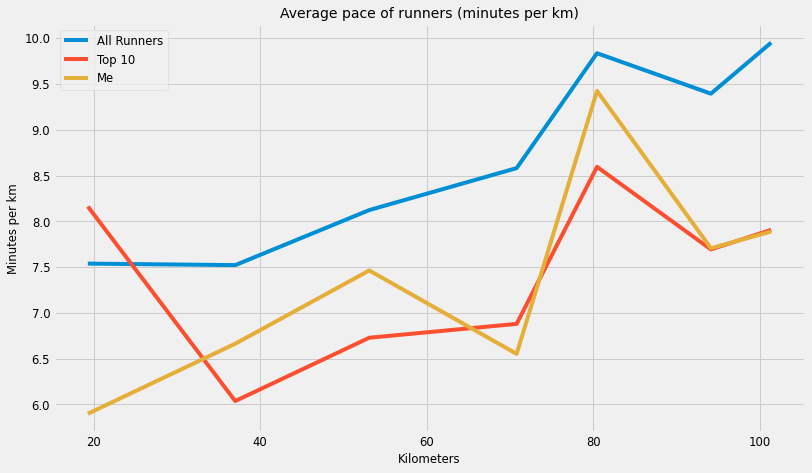

In [12]:
plots.plot(y = ["All Runners","Top 10","Me"], x = "cp_km_all", figsize=(12,7))
plt.title('Average pace of runners (minutes per km)')
plt.ylabel('Minutes per km', fontsize="small")
plt.xlabel('Kilometers')
plt.show()